<a href="https://colab.research.google.com/github/sameer693/fuzzy-pancake/blob/main/political__speechanalysis_cse_50and37.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install spacy --upgrade
!python -m spacy download en_core_web_lg
!pip3 install textacy

In [ ]:
import spacy
import random
from collections import Counter #for counting
import seaborn as sns #for visualization
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
plt.style.use('seaborn')
sns.set(font_scale=2)
import json
def pretty_print(pp_object):
    print(json.dumps(pp_object, indent=2))

from IPython.display import Markdown, display
def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

#spacyload
nlp = spacy.load('en_core_web_lg')

tweet_path = r"/content/all_djt_tweets[1].csv"#data path
tweets = pd.read_csv(tweet_path)

<ipython-input-8-f62f67f5201e>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
def explain_text_entities(text):
    doc = nlp(text)
    for ent in doc.ents:
        print(f'Entity: {ent}, Label: {ent.label_}, {spacy.explain(ent.label_)}')
explain_text_entities(tweets['text'][9])


Entity: Friday, Label: DATE, Absolute or relative dates or periods
Entity: Congratulations U.S.A., Label: ORG, Companies, agencies, institutions, etc.


In [ ]:
one_sentence = tweets['text'][0]
doc = nlp(one_sentence)
spacy.displacy.render(doc, style='ent',jupyter=True)

one_sentence = tweets['text'][240]
doc = nlp(one_sentence)
spacy.displacy.render(doc, style='ent',jupyter=True)

In [ ]:
#redacted names
def redact_names(text):
    doc = nlp(text)
    redacted_sentence = []
    with doc.retokenize() as retokenizer:
        for ent in doc.ents:
            retokenizer.merge(ent)
    for token in doc:
        if token.ent_type_ == "PERSON":
            redacted_sentence.append("[REDACTED]")
        else:
            redacted_sentence.append(token.text)
    return " ".join(redacted_sentence)
printmd("**Before**", color="blue")
one_sentence = tweets['text'][450]
doc = nlp(one_sentence)
spacy.displacy.render(doc, style='ent',jupyter=True)
printmd("**After**", color="blue")
one_sentence = redact_names(tweets['text'][450])
doc = nlp(one_sentence)
spacy.displacy.render(doc, style='ent',jupyter=True)

printmd("Notice that `Obama W.H.` was removed", color="#6290c8")

<span style='color:blue'>**Before**</span>

<span style='color:blue'>**After**</span>

<span style='color:#6290c8'>Notice that `Obama W.H.` was removed</span>

##what trump talks about?

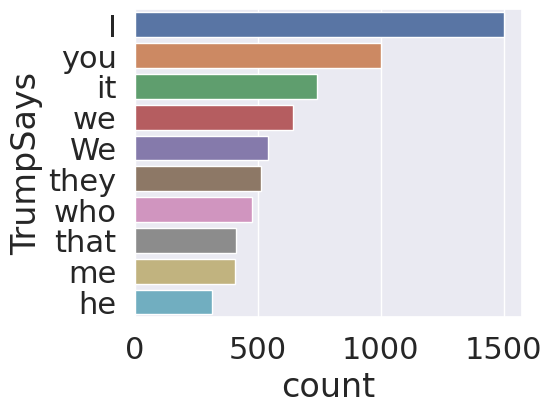

In [ ]:
text = tweets['text'].str.cat(sep=' ')
# spaCy enforces a max limit of 1000000 characters for NER and similar use cases.
# Since `text` might be longer than that, we will slice it off here
max_length = 1000000-1
text = text[:max_length]

# removing URLs and '&amp' substrings using regex
import re
url_reg  = r'[a-z]*[:.]+\S+'
text   = re.sub(url_reg, '', text)
noise_reg = r'\&amp'
text   = re.sub(noise_reg, '', text)
doc = nlp(text)
items_of_interest = list(doc.noun_chunks)
# each element in this list is spaCy's inbuilt `Span`, which is not useful for us
items_of_interest = [str(x) for x in items_of_interest]
# so we've converted it to string
df_nouns = pd.DataFrame(items_of_interest, columns=["TrumpSays"])
plt.figure(figsize=(5,4))
sns.countplot(y="TrumpSays",
             data=df_nouns,
             order=df_nouns["TrumpSays"].value_counts().iloc[:10].index)
plt.show()

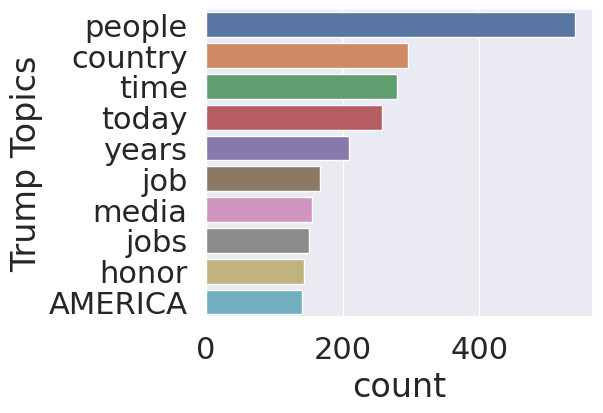

In [ ]:
trump_topics = []
for token in doc:
    if (not token.is_stop) and (token.pos_ == "NOUN") and (len(str(token))>2):
        trump_topics.append(token)

trump_topics = [str(x) for x in trump_topics]
df_nouns = pd.DataFrame(trump_topics, columns=["Trump Topics"])
df_nouns
plt.figure(figsize=(5,4))
sns.countplot(y="Trump Topics",
             data=df_nouns,
             order=df_nouns["Trump Topics"].value_counts().iloc[:10].index)
plt.show()

##Exploring Entities

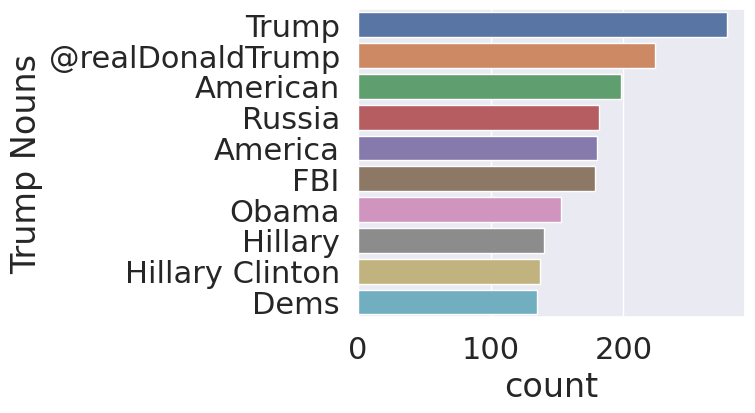

In [ ]:
trump_topics = []
for ent in doc.ents:
    if ent.label_ not in ["PERCENT", "CARDINAL", "DATE"]:
#         print(ent.text,ent.label_)
        trump_topics.append(ent.text.strip())
df_ttopics = pd.DataFrame(trump_topics, columns=["Trump Nouns"])
plt.figure(figsize=(5,4))
sns.countplot(y="Trump Nouns",
             data=df_ttopics,
             order=df_ttopics["Trump Nouns"].value_counts().iloc[1:11].index)
plt.show()

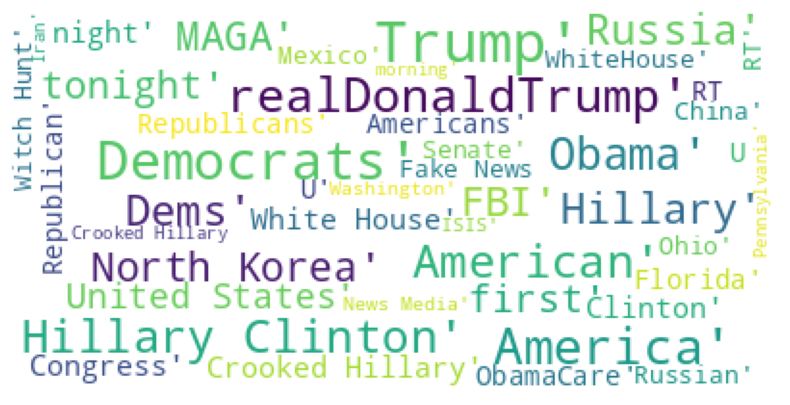

In [ ]:
from spacy.lang.en.stop_words import STOP_WORDS
from wordcloud import WordCloud
plt.figure(figsize=(10,5))
wordcloud = WordCloud(background_color="white",
                      stopwords = STOP_WORDS,
                      max_words=45,
                      max_font_size=30,
                      random_state=42
                     ).generate(str(trump_topics))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
from spacy.matcher import Matcher
# doc = nlp(text)
matcher = Matcher(nlp.vocab)
matched_sents = [] # collect data of matched sentences to be visualized

def collect_sents(matcher, doc, i, matches, label='MATCH'):
    """
    Function to help reformat data for displacy visualization
    """
    match_id, start, end = matches[i]
    span = doc[start : end]  # matched span
    sent = span.sent  # sentence containing matched span

    # append mock entity for match in displaCy style to matched_sents

    if doc.vocab.strings[match_id] == 'DEMOCRATS':  # don't forget to get string!
        match_ents = [{'start': span.start_char - sent.start_char,
                   'end': span.end_char - sent.start_char,
                   'label': 'DEMOCRATS'}]
        matched_sents.append({'text': sent.text, 'ents': match_ents })
    elif doc.vocab.strings[match_id] == 'RUSSIA':  # don't forget to get string!
        match_ents = [{'start': span.start_char - sent.start_char,
               'end': span.end_char - sent.start_char,
               'label': 'RUSSIA'}]
        matched_sents.append({'text': sent.text, 'ents': match_ents })
    elif doc.vocab.strings[match_id] == 'I':  # don't forget to get string!
        match_ents = [{'start': span.start_char - sent.start_char,
               'end': span.end_char - sent.start_char,
               'label': 'NARC'}]
        matched_sents.append({'text': sent.text, 'ents': match_ents })
# # declare different patterns
russia_pattern = [[{'LOWER': 'russia'}, {'LEMMA': 'be'}, {'POS': 'ADV', 'OP': '*'},
           {'POS': 'ADJ'}]]
democrats_pattern = [[{'LOWER': 'democrats'}, {'LEMMA': 'be'}, {'POS': 'ADV', 'OP': '*'},
           {'POS': 'ADJ'}]]
i_pattern = [[{'LOWER': 'i'}, {'LEMMA': 'be'}, {'POS': 'ADV', 'OP': '*'},
           {'POS': 'ADJ'}]]
matcher.add('DEMOCRATS', democrats_pattern, on_match=collect_sents)  # add pattern
matcher.add('RUSSIA', russia_pattern, on_match=collect_sents) # add pattern
matcher.add('I', i_pattern, on_match=collect_sents)  # add pattern
matches = matcher(doc)
#now render what he talks about them
spacy.displacy.render(matched_sents, style='ent', manual=True, jupyter=True,  options = {'colors': {'NARC': '#6290c8', 'RUSSIA': '#cc2936', 'DEMOCRATS':'#f2cd5d'}})

##Question Generation using Dependency Parsing

In [ ]:
from textacy.spacier import utils as spacy_utils

def para_to_ques(eg_text):
    """
    Generates a few simple questions by slot filling pieces from sentences
    """
    doc = nlp(eg_text)
    results = []
    for sentence in doc.sents:
        root = sentence.root
        ask_about = spacy_utils.get_subjects_of_verb(root)
        answers = spacy_utils.get_objects_of_verb(root)
        if len(ask_about) > 0 and len(answers) > 0:
            if root.lemma_ == "be":
                question = f'What {root} {ask_about[0]}?'
            else:
                question = f'What does {ask_about[0]} {root.lemma_}?'
            results.append({'question':question, 'answers':answers})
    return results
example_text = tweets['text'][180]
example_text2 = tweets['text'][90]
example_text3 = tweets['text'][241]
doc = nlp(example_text)
spacy.displacy.render(doc, style='ent', jupyter=True)
print(para_to_ques(example_text))
doc = nlp(example_text2)
spacy.displacy.render(doc, style='ent', jupyter=True)
print(para_to_ques(example_text2))
doc = nlp(example_text3)
spacy.displacy.render(doc, style='ent', jupyter=True)
print(para_to_ques(example_text3))

[{'question': 'What does Omarosa have?', 'answers': [Agreement]}]


[{'question': 'What does I allow?', 'answers': [McGahn]}, {'question': 'What does we give?', 'answers': [pages]}]


[{'question': 'What does Troy love?', 'answers': [Ohio]}]
